In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="test")
location = geolocator.geocode(u"nashville")

print(location.address)       #住所
print(location.latitude)      #緯度
print(location.longitude)     #経度
print(location.raw)           #ジオコーディングした結果の全ての情報

Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States
36.1622767
-86.7742984
{'place_id': 298048751, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 197472, 'lat': '36.1622767', 'lon': '-86.7742984', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6474694013099324, 'addresstype': 'city', 'name': 'Nashville-Davidson', 'display_name': 'Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States', 'boundingbox': ['35.9677850', '36.4054960', '-87.0547660', '-86.5155880']}


In [34]:
import unicodedata
from pathlib import Path
!pip install scikit-learn==1.3.0

import os

!pip install catboost
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install category_encoders
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import TargetEncoder

from geopy.geocoders import Nominatim
# geolocator = Nominatim()

from geopy.extra.rate_limiter import RateLimiter
import time

In [35]:
INPUT_DIR = '/content/drive/MyDrive/signate/Student Cup 2023/input'

df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,rwd,compact,truck,black,pa,32212
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,rwd,full-size,pickup,black,NaN,5400
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,4wd,mid-size,SUV,white,ny,22227
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,4wd,mid-size,sedan,white,ny,3054


In [36]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sub_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "price"])

In [37]:
train_df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64

In [38]:
test_df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1495
odometer           0
title_status     229
transmission       0
drive              0
size               0
type             229
paint_color        0
state           3029
dtype: int64

In [39]:
train_df['state'].unique()

array([nan, 'pa', 'ks', 'ny', 'ca', 'al', 'or', 'va', 'mt', 'nj', 'ma',
       'wi', 'sc', 'wa', 'dc', 'oh', 'in', 'de', 'fl', 'nm', 'az', 'ok',
       'mn', 'co', 'nv', 'wv', 'tn', 'mi', 'ri', 'il', 'tx', 'ut', 'ia',
       'ga', 'md', 'mo', 'ky', 'nc', 'ak', 'id', 'ct', 'wy', 'nd', 'me',
       'ar', 'hi', 'sd', 'ne', 'nh', 'vt', 'la', 'ms'], dtype=object)

In [40]:
# region -> stateが一意に定まることを確認
region_state = {region:{} for region in train_df['region'].unique()}
for row, value in train_df.iterrows():
    if not pd.isna(value['state']):
        if value['state'] not in region_state[value['region']]:
            region_state[value['region']][value['state']] = 1
        else:
            region_state[value['region']][value['state']] += 1

for region, state_dict in region_state.items():
    if len(state_dict) > 1 or state_dict == {}:
        region_state[region] = pd.NA
    else:
        region_state[region] = list(state_dict.keys())[0]

# regionからstateを決定
train_df['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(train_df['region'], train_df['state'])]
test_df['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(test_df['region'], test_df['state'])]

In [41]:
agg_col = ["condition", "fuel", "transmission"]
# manufacturer  paint_color v

for x in agg_col:
    grouped = train_df.groupby(x)['odometer']
    agg_data = grouped.agg(
        **{
            f"{x}_median_odometer": 'median',
            f"{x}_mean_odometer": 'mean'
        }
    ).reset_index()

    # 元のデータフレームに計算結果をマージ
    train_df = train_df.merge(agg_data, on=x, how='left')
    test_df = test_df.merge(agg_data, on=x, how='left')

In [42]:
train_df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,...,type,paint_color,state,price,condition_median_odometer,condition_mean_odometer,fuel_median_odometer,fuel_mean_odometer,transmission_median_odometer,transmission_mean_odometer
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,...,convertible,orange,tn,27587,106935.0,110741.941258,111788.5,116586.508961,121557.5,125686.500000
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,...,sedan,silver,pa,4724,147174.0,153475.427205,111788.5,116586.508961,109269.0,113500.068888
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,...,SUV,silver,ks,10931,126397.0,127622.489100,111788.5,116586.508961,109269.0,113500.068888
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,...,SUV,blue,ny,16553,106935.0,110741.941258,111788.5,116586.508961,121557.5,125686.500000
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,...,sedan,red,ca,5158,106935.0,110741.941258,111788.5,116586.508961,121557.5,125686.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,...,truck,black,pa,32212,126397.0,127622.489100,111788.5,116586.508961,109269.0,113500.068888
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,...,pickup,black,ok,5400,106935.0,110741.941258,111788.5,116586.508961,109269.0,113500.068888
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,...,SUV,white,ny,22227,92054.0,95643.998688,111788.5,116586.508961,109269.0,113500.068888
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,...,sedan,white,ny,3054,106935.0,110741.941258,111788.5,116586.508961,109269.0,113500.068888


In [43]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    # X["title_status"] = X["title_status"].fillna("clean")

    # cylinderから数値を取り出す
    X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").astype("float32")
    # X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").fillna(0).astype("float32")


    # sizeの表記揺れを修正
    X["size"] = X["size"].str.replace("ー", "-").astype(str)
    X["size"] = X["size"].str.replace("−", "-").astype(str)

    # 順位付け: サイズ別に値を割り当てます。大きいほど高い値にします。
    ranking_dict = {'full-size': 4, 'mid-size': 3, 'compact': 2, 'sub-compact': 1}

    # 新しい順位カラムを作成します。
    X['size_rank'] = X['size'].map(ranking_dict)

    # manufacturerの表記揺れを修正
    X["manufacturer"] = X["manufacturer"].apply(
        lambda x: unicodedata.normalize("NFKC", x).lower()
    )

    # 正規化の辞書
    normalize_dict = {
        'niѕsan': 'nissan',
        'subαru': 'subaru',
        'toyotа': 'toyota',
        'sαturn': 'saturn',
        'аcura': 'acura',
        'vоlkswagen': 'volkswagen',
        'lexuѕ': 'lexus',
        'ᴄhrysler': 'chrysler'
    }


    # データフレームのメーカー名を正規化
    X['manufacturer'] = X['manufacturer'].map(lambda x: normalize_dict.get(x, x))

    # 国別分類
    def classify_country(manufacturer):
        if pd.isnull(manufacturer):
            return 'Unknown'
        if manufacturer in ['bmw', 'volkswagen', 'audi', 'mercedes-benz', 'porsche']:
            return 'Germany'
        elif manufacturer in ['toyota', 'nissan', 'lexus', 'subaru', 'honda', 'mazda', 'mitsubishi', 'infiniti', 'acura']:
            return 'Japan'
        elif manufacturer in ['ford', 'buick', 'ram', 'dodge', 'chevrolet', 'jeep', 'chrysler', 'gmc', 'lincoln', 'cadillac', 'pontiac', 'saturn']:
            return 'USA'
        elif manufacturer in ['hyundai', 'kia']:
            return 'South Korea'
        elif manufacturer in ['fiat', 'alfa-romeo']:
            return 'Italy'
        elif manufacturer in ['land rover', 'jaguar', 'aston-martin', 'rover']:
            return 'UK'
        else:
            return 'Unknown'

    X['country'] = X['manufacturer'].apply(classify_country)


    def classify_color(color):
        if color in ['orange', 'yellow', 'red', 'white']:
            return 'Bright'
        elif color in ['black', 'brown', 'green', 'blue']:
            return 'Dark'
        elif color in ['silver', 'grey']:
            return 'Neutral'
        elif color in ['purple', 'custom']:
            return 'Special'
        else:
            return 'Unknown'

    X['color_category'] = X['paint_color'].apply(classify_color)

    # one-hot encoding
    # X = pd.get_dummies(X, columns=['country'])

    # yearが3000年以降のものはおかしいので2000年に置換
    err_idx = X.query("year >= 3000").index
    X.loc[err_idx, "year"] = X.loc[err_idx, "year"].apply(lambda x: x - 1000)

    # 走行距離 / 製造年
    X["odometer_per_year"] = X["odometer"] / (2023 - X["year"])

    for col in agg_col:
      X[f"{col}_diff_mean"] = X["odometer"] - X[f"{x}_mean_odometer"]
      X[f"{col}_diff_median"] = X["odometer"] - X[f"{x}_median_odometer"]

    # X["pass_year"] = 2023 - X["year"]

    # X['state'] = X['state'].replace('<NA>', 'null')
    # X.dropna(subset=['state'], inplace=True)
    X['state'] = X['state'].fillna("unknown")

    err_idx = X.query("odometer < -1").index
    X.loc[err_idx, "odometer"] = X.loc[err_idx, "odometer"].apply(lambda x: -1)

    # Geolocatorオブジェクトを作成
    geolocator = Nominatim(user_agent="gabikueh")

    # ユニークなregionを取得
    unique_regions = X['region'].unique()

    # 緯度経度の辞書を作成
    lat_lon_dict = {}

    for city in unique_regions:
        try:
            location = geolocator.geocode(city)
            if location:
                lat_lon_dict[city] = {'latitude': location.latitude, 'longitude': location.longitude}
                print(location.raw)  # ジオコーディングした結果の全ての情報
            else:
                lat_lon_dict[city] = {'latitude': None, 'longitude': None}
                print(f"Failed to geocode for city: {city}")
        except Exception as e:
            lat_lon_dict[city] = {'latitude': None, 'longitude': None}
            print(f"Error geocoding city: {city}. Error message: {e}")
        time.sleep(2)  # 1秒待機

    # ユニークな地域の緯度経度を元のデータフレームにマージ
    geo_df = pd.DataFrame.from_dict(lat_lon_dict, orient='index').reset_index().rename(columns={'index': 'region'})
    X = X.merge(geo_df, on='region', how='left')

    return X

class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols

In [44]:
result_agg_cols = [f"{x}_diff_{stat}" for x in agg_col for stat in ['mean', 'median']]
numeric_cols = ["year", "odometer", "odometer_per_year", "size_rank", "latitude", "longitude"] + result_agg_cols
categorical_cols = [
    'region',
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
    "country",
    "color_category"
]

ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            categorical_cols + numeric_cols,
        ),
        (
            "tgt",
            TargetEncoder(target_type="continuous", random_state=88),
            [
                'region',
                "cylinders",
                "manufacturer",
                "condition",
                "fuel",
                "title_status",
                "transmission",
                "drive",
                "size",
                "type",
                "paint_color",
                "state",
                "country",
                "color_category"
            ],
        ),
        # *[
        #     (f"agg_{key}", AggTransformer(key, ["odometer"], {"mean"}), [key] + ["odometer"])
        #     for key in [
        #         "manufacturer",
        #     ]
        # ],
    ],
    verbose=True,
)
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)
train_feat_df = pipe.fit_transform(train_df, train_df["price"])
test_feat_df = pipe.transform(test_df)


{'place_id': 298048751, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 197472, 'lat': '36.1622767', 'lon': '-86.7742984', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6474694013099324, 'addresstype': 'city', 'name': 'Nashville-Davidson', 'display_name': 'Nashville-Davidson, Davidson County, Middle Tennessee, Tennessee, United States', 'boundingbox': ['35.9677850', '36.4054960', '-87.0547660', '-86.5155880']}
{'place_id': 299449022, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 188627, 'lat': '40.7944504', 'lon': '-77.8616386', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.46200246531290373, 'addresstype': 'city', 'name': 'State College', 'display_name': 'State College, Centre County, Pennsylvania, United States', 'boundingbox': ['40.7683701', '40.8072297', '-77.8861677', '-77

{'place_id': 298007457, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 142497, 'lat': '45.7874957', 'lon': '-108.49607', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5171823124155172, 'addresstype': 'city', 'name': 'Billings', 'display_name': 'Billings, Yellowstone County, Montana, United States', 'boundingbox': ['45.7106730', '45.8526530', '-108.6915190', '-108.4359160']}
{'place_id': 362341680, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 113006, 'lat': '35.3738712', 'lon': '-119.0194639', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5768878088246248, 'addresstype': 'city', 'name': 'Bakersfield', 'display_name': 'Bakersfield, Kern County, CAL Fire Southern Region, California, United States', 'boundingbox': ['35.1939790', '35.4473018', '-119.2650330', '-118.7723410']}
{'pl

{'place_id': 298056177, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 237752, 'lat': '46.601557', 'lon': '-120.510842', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.49861201427065993, 'addresstype': 'city', 'name': 'Yakima', 'display_name': 'Yakima, Yakima County, Washington, United States', 'boundingbox': ['46.5572920', '46.6307770', '-120.6444942', '-120.4603350']}
{'place_id': 298785847, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 5396194, 'lat': '38.8950368', 'lon': '-77.0365427', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.7492888986115819, 'addresstype': 'city', 'name': 'Washington', 'display_name': 'Washington, District of Columbia, United States', 'boundingbox': ['38.7916303', '38.9959680', '-77.1197949', '-76.9093660']}
{'place_id': 298545436, 'licence': 'Data ©

{'place_id': 298113246, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 242595, 'lat': '-29.6860512', 'lon': '-53.8069214', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5194871087039776, 'addresstype': 'municipality', 'name': 'Santa Maria', 'display_name': 'Santa Maria, Região Geográfica Imediata de Santa Maria, Região Geográfica Intermediária de Santa Maria, Rio Grande do Sul, Região Sul, Brasil', 'boundingbox': ['-30.0056759', '-29.5493913', '-54.1368461', '-53.5168897']}
{'place_id': 144093201, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 165271238, 'lat': '14.6743343', 'lon': '121.1003603', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'Detroit', 'display_name': 'Detroit, Buenavista Ville, 2nd District, Quezon City, Eastern Manila 

{'place_id': 299489310, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 11000241, 'lat': '34.539984', 'lon': '-112.468812', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5190275667551049, 'addresstype': 'city', 'name': 'Prescott', 'display_name': 'Prescott, Yavapai County, Arizona, United States', 'boundingbox': ['34.5125262', '34.6799352', '-112.5299550', '-112.3760980']}
{'place_id': 362976765, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 130719, 'lat': '36.9903199', 'lon': '-86.4436018', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5164935180257069, 'addresstype': 'city', 'name': 'Bowling Green', 'display_name': 'Bowling Green, Warren County, Kentucky, 42101, United States', 'boundingbox': ['36.8988470', '37.0466520', '-86.5332070', '-86.3067190']}
{'place_id': 297990236, 

Error geocoding city: east oregon. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=east+oregon&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


{'place_id': 124276133, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 83337046, 'lat': '41.6700891', 'lon': '-70.32877031452514', 'class': 'place', 'type': 'island', 'place_rank': 17, 'importance': 0.32500009999999996, 'addresstype': 'island', 'name': 'Gooseberry Island', 'display_name': 'Gooseberry Island, Centerville, Barnstable, Barnstable County, Massachusetts, United States', 'boundingbox': ['41.6699076', '41.6702877', '-70.3292050', '-70.3283723']}


{'place_id': 177450169, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 296971301, 'lat': '44.08173035', 'lon': '-103.23548712433035', 'class': 'office', 'type': 'government', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'office', 'name': 'Rapid City Department of Parks and Recreation', 'display_name': 'Rapid City Department of Parks and Recreation, 515, West Boulevard, Rapid City, Pennington County, South Dakota, 57701, United States', 'boundingbox': ['44.0815428', '44.0819438', '-103.2358068', '-103.2352885']}
{'place_id': 106896608, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 16479341, 'lat': '35.745395', 'lon': '-81.361333', 'class': 'highway', 'type': 'tertiary', 'place_rank': 26, 'importance': 0.10000009999999993, 'addresstype': 'road', 'name': 'Old Lenoir Road', 'display_name': 'Old Lenoir Road, Hickory, Catawba County, No

Failed to geocode for city: raleigh / durham / CH
{'place_id': 298648601, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 396505, 'lat': '34.4458248', 'lon': '-119.0779359', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5603691549944142, 'addresstype': 'county', 'name': 'Ventura County', 'display_name': 'Ventura County, CAL Fire Contract Counties, California, United States', 'boundingbox': ['33.1634930', '34.9012713', '-119.7577028', '-118.6324850']}
{'place_id': 364757023, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1411339, 'lat': '39.7392364', 'lon': '-104.984862', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.595475873909579, 'addresstype': 'city', 'name': 'Denver', 'display_name': 'Denver, Colorado, United States', 'boundingbox': ['39.6143008', '39.9142087', '-105.109884

{'place_id': 298036313, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 169478, 'lat': '41.1238873', 'lon': '-100.7654232', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4658495225709983, 'addresstype': 'city', 'name': 'North Platte', 'display_name': 'North Platte, Lincoln County, Nebraska, 69101, United States', 'boundingbox': ['41.0900170', '41.1653760', '-100.8150840', '-100.7040620']}
{'place_id': 298014521, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 129088, 'lat': '41.9758872', 'lon': '-91.6704053', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.537150279903087, 'addresstype': 'city', 'name': 'Cedar Rapids', 'display_name': 'Cedar Rapids, Linn County, Iowa, United States', 'boundingbox': ['41.8615994', '42.0689041', '-91.7745806', '-91.5510589']}
{'place_id': 297980425, 

{'place_id': 230030597, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 608482607, 'lat': '41.31611085', 'lon': '-74.12629189225156', 'class': 'landuse', 'type': 'retail', 'place_rank': 22, 'importance': 0.2000000999999999, 'addresstype': 'retail', 'name': 'Hudson Valley', 'display_name': 'Hudson Valley, Village of Woodbury, Town of Woodbury, Orange County, New York, United States', 'boundingbox': ['41.3140017', '41.3183200', '-74.1284261', '-74.1240530']}
{'place_id': 299488325, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 11078268, 'lat': '38.0464066', 'lon': '-84.4970393', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5818846699201988, 'addresstype': 'city', 'name': 'Lexington', 'display_name': 'Lexington, Fayette County, Kentucky, United States', 'boundingbox': ['37.8452952', '38.2114040', '-84.6604150', '-84.28

{'place_id': 298119637, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 396504, 'lat': '37.1641544', 'lon': '-120.7678602', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5454256195956947, 'addresstype': 'county', 'name': 'Merced County', 'display_name': 'Merced County, CAL Fire Southern Region, California, United States', 'boundingbox': ['36.7404189', '37.6335083', '-121.2476184', '-120.0524763']}
{'place_id': 1068485, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 298788390, 'lat': '39.4797189', 'lon': '-88.3215233', 'class': 'highway', 'type': 'motorway_junction', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'highway', 'name': 'Charleston', 'display_name': 'Charleston, I 57, Mattoon, Coles County, Illinois, 61938, United States', 'boundingbox': ['39.4796689', '39.4797689', '-88.3215733', '-

{'place_id': 297979191, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 112224, 'lat': '34.4221319', 'lon': '-119.702667', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5840479382888756, 'addresstype': 'city', 'name': 'Santa Barbara', 'display_name': 'Santa Barbara, Santa Barbara County, CAL Fire Contract Counties, California, United States', 'boundingbox': ['34.3360290', '34.4639220', '-119.8597910', '-119.6399059']}
{'place_id': 2519221, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 357605408, 'lat': '43.1753474', 'lon': '-75.3504478', 'class': 'man_made', 'type': 'tower', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'man_made', 'name': 'WRUN-AM (Utica)', 'display_name': 'WRUN-AM (Utica), Erie Canalway Trail, Village of Oriskany, Town of Whitestown, Oneida County, New York, 13424, United S

{'place_id': 298037141, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 185207, 'lat': '36.1156306', 'lon': '-97.0585717', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5059258240264476, 'addresstype': 'city', 'name': 'Stillwater', 'display_name': 'Stillwater, Payne County, Oklahoma, United States', 'boundingbox': ['36.0790554', '36.2045006', '-97.1495688', '-97.0153924']}
{'place_id': 298363011, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 187550, 'lat': '42.1294712', 'lon': '-80.0852695', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5527908593636566, 'addresstype': 'city', 'name': 'Erie', 'display_name': 'Erie, Erie County, Pennsylvania, United States', 'boundingbox': ['42.0772638', '42.1536477', '-80.1386671', '-80.0035087']}
{'place_id': 71263690, 'licence': 'Data © OpenS

{'place_id': 114775890, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 33114125, 'lat': '40.4274105', 'lon': '-120.65370334155844', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4580453307098361, 'addresstype': 'city', 'name': 'Susanville', 'display_name': 'Susanville, Lassen County, California, 96130, United States', 'boundingbox': ['40.4012500', '40.4535570', '-120.6741370', '-120.6066430']}
{'place_id': 298023900, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 161652, 'lat': '44.6471761', 'lon': '-100.348761', 'class': 'boundary', 'type': 'administrative', 'place_rank': 8, 'importance': 0.6952715821164077, 'addresstype': 'state', 'name': 'South Dakota', 'display_name': 'South Dakota, United States', 'boundingbox': ['42.4798925', '45.9454500', '-104.0577568', '-96.4363403']}
{'place_id': 2633678, 'licence': 'Data ©

{'place_id': 347854920, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 141747, 'lat': '37.0841838', 'lon': '-94.5133385', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5191360029376799, 'addresstype': 'city', 'name': 'Joplin', 'display_name': 'Joplin, Jasper County, Missouri, United States', 'boundingbox': ['37.0170140', '37.1736530', '-94.5774257', '-94.4403550']}
{'place_id': 298732340, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 4644852, 'lat': '46.10545475', 'lon': '-89.97800809043656', 'class': 'boundary', 'type': 'protected_area', 'place_rank': 25, 'importance': 0.30799018260571026, 'addresstype': 'protected_area', 'name': 'Northern Highland American Legion State Forest', 'display_name': 'Northern Highland American Legion State Forest, Iron County, Wisconsin, United States', 'boundingbox': ['45.7323830'

{'place_id': 298191441, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 911303, 'lat': '41.2951563', 'lon': '-83.1555438', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.513391679958487, 'addresstype': 'county', 'name': 'Sandusky County', 'display_name': 'Sandusky County, Ohio, United States', 'boundingbox': ['41.2528780', '41.5011890', '-83.4200590', '-82.8402250']}
{'place_id': 298971439, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 6603682, 'lat': '33.44667445', 'lon': '-94.07714830522015', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5251688115617561, 'addresstype': 'city', 'name': 'Texarkana', 'display_name': 'Texarkana, Bowie County, Texas, United States', 'boundingbox': ['33.3813921', '33.5119622', '-94.1709726', '-94.0430416']}
{'place_id': 297994421, 'licence': 'Data 

{'place_id': 202012364, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 423269898, 'lat': '46.3811136', 'lon': '-105.82484779798801', 'class': 'landuse', 'type': 'cemetery', 'place_rank': 22, 'importance': 0.2000000999999999, 'addresstype': 'cemetery', 'name': 'Eastern Montana State Veterans Cemetery', 'display_name': 'Eastern Montana State Veterans Cemetery, Miles City, Custer County, Montana, 59301, United States', 'boundingbox': ['46.3792317', '46.3828076', '-105.8277693', '-105.8225873']}
{'place_id': 107500712, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 19192199, 'lat': '39.9700862', 'lon': '-82.0089733', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'Cambridge Avenue', 'display_name': 'Cambridge Avenue, Zanesville, Muskingum County, Ohio, 43701, United States', 'bound

{'place_id': 298334312, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1799705, 'lat': '42.321246', 'lon': '-88.8235511', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5382326327811843, 'addresstype': 'county', 'name': 'Boone County', 'display_name': 'Boone County, Illinois, United States', 'boundingbox': ['42.1523286', '42.4950185', '-88.9405900', '-88.7055866']}
{'place_id': 298124976, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 405844, 'lat': '38.1443725', 'lon': '-92.65947435867777', 'class': 'natural', 'type': 'water', 'place_rank': 22, 'importance': 0.3146916706215691, 'addresstype': 'water', 'name': 'Lake Of The Ozarks', 'display_name': 'Lake Of The Ozarks, Osage Beach, Camden County, Missouri, 65079, United States', 'boundingbox': ['37.9582476', '38.3305000', '-93.4059191', '-92.5264145']}
{'place_id'

Error geocoding city: southern illinois. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=southern+illinois&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 298644762, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 3871059, 'lat': '30.40711375', 'lon': '-89.07143302103171', 'class': 'aeroway', 'type': 'aerodrome', 'place_rank': 30, 'importance': 0.2874189406975713, 'addresstype': 'aeroway', 'name': 'Gulfport-Biloxi International Airport', 'display_name': 'Gulfport-Biloxi International Airport, Airport Road, North Gulfport, Gulfport, Harrison County, Mississippi, 39503, United States', 'boundingbox': ['30.3937865', '30.4198528', '-89.0892407', '-89.0578847']}
{'place_id': 298445033, 'licence': 'Data © OpenStreetMap contributors, O

{'place_id': 298003928, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 136899, 'lat': '44.6402434', 'lon': '-93.1435497', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.46487738255238253, 'addresstype': 'city', 'name': 'Farmington', 'display_name': 'Farmington, Dakota County, Minnesota, 55024, United States', 'boundingbox': ['44.6232928', '44.6921749', '-93.2076268', '-93.1163862']}
{'place_id': 437236, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 158402758, 'lat': '39.9751127', 'lon': '-75.1629555', 'class': 'place', 'type': 'neighbourhood', 'place_rank': 20, 'importance': 0.25000009999999995, 'addresstype': 'neighbourhood', 'name': 'North Central', 'display_name': 'North Central, Philadelphia, Philadelphia County, Pennsylvania, 19121, United States', 'boundingbox': ['39.9651127', '39.9851127', '-75.1729555', '-75

{'place_id': 298451437, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 2552485, 'lat': '40.7814865', 'lon': '-73.95905442771002', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.6754391745917971, 'addresstype': 'county', 'name': 'New York County', 'display_name': 'New York County, City of New York, New York, United States', 'boundingbox': ['40.6796540', '40.8820120', '-74.0472070', '-73.9067690']}


{'place_id': 218050136, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 521971846, 'lat': '30.1942384', 'lon': '-98.05324217912107', 'class': 'craft', 'type': 'distillery', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'craft', 'name': 'Deep Eddy Distillery', 'display_name': 'Deep Eddy Distillery, East US Highway 290, Dripping Springs, Hays County, Texas, United States', 'boundingbox': ['30.1939966', '30.1944601', '-98.0536134', '-98.0527623']}
{'place_id': 274543300, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 893839350, 'lat': '41.892231699999996', 'lon': '-103.68260709673888', 'class': 'amenity', 'type': 'university', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'amenity', 'name': 'University of Nebraska-Lincoln Panhandle Research and Extension Center', 'display_name': 'University of Nebraska-Lincoln Pa

Error geocoding city: del rio / eagle pass. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=del+rio+%2F+eagle+pass&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 289772407, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 1000038115, 'lat': '34.19768', 'lon': '-103.3246785', 'class': 'highway', 'type': 'trunk', 'place_rank': 26, 'importance': 0.10000009999999993, 'addresstype': 'road', 'name': 'Clovis Highway', 'display_name': 'Clovis Highway, Portales, Roosevelt County, New Mexico, 88130, United States', 'boundingbox': ['34.1930299', '34.2026760', '-103.3309645', '-103.3177082']}
{'place_id': 297996194, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 129229, 'lat'

Error geocoding city: cumberland valley. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=cumberland+valley&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 297971860, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 110720, 'lat': '33.9471315', 'lon': '-86.4714926', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4502362775822694, 'addresstype': 'city', 'name': 'Oneonta', 'display_name': 'Oneonta, Blount County, Alabama, 35121, United States', 'boundingbox': ['33.8773870', '33.9877020', '-86.5830930', '-86.4450940']}
{'place_id': 147111376, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 173549766, 'lat': '14.470892', 'lon': '120.9999

{'place_id': 274641702, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 894257202, 'lat': '32.7478654', 'lon': '-97.3113386', 'class': 'highway', 'type': 'motorway', 'place_rank': 26, 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'Tom Landry Freeway', 'display_name': 'Tom Landry Freeway, Fort Worth, Tarrant County, Texas, 76102, United States', 'boundingbox': ['32.7478311', '32.7479421', '-97.3122561', '-97.3093806']}
{'place_id': 298034597, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 119009, 'lat': '30.4380832', 'lon': '-84.2809332', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.574009550684315, 'addresstype': 'city', 'name': 'Tallahassee', 'display_name': 'Tallahassee, Leon County, Florida, United States', 'boundingbox': ['30.3466959', '30.5872436', '-84.3780355', '-84.1299504']}
{'place_id': 

{'place_id': 298034835, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 166563, 'lat': '19.593801499999998', 'lon': '-155.42837009716908', 'class': 'boundary', 'type': 'administrative', 'place_rank': 8, 'importance': 0.7204326433963092, 'addresstype': 'state', 'name': 'Hawaii', 'display_name': 'Hawaii, United States', 'boundingbox': ['18.8654600', '28.5172690', '-178.4435930', '-154.7557920']}
{'place_id': 298029518, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 175031, 'lat': '42.8867166', 'lon': '-78.8783922', 'class': 'boundary', 'type': 'administrative', 'place_rank': 14, 'importance': 0.6229312091953605, 'addresstype': 'city', 'name': 'Buffalo', 'display_name': 'Buffalo, Erie County, New York, United States', 'boundingbox': ['42.8260060', '42.9664490', '-78.9223570', '-78.7951210']}
{'place_id': 298119637, 'licence': 'Data © OpenStreetMap co

{'place_id': 297949587, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 60759, 'lat': '44.5990718', 'lon': '-72.5002608', 'class': 'boundary', 'type': 'administrative', 'place_rank': 8, 'importance': 0.6908779873572128, 'addresstype': 'state', 'name': 'Vermont', 'display_name': 'Vermont, United States', 'boundingbox': ['42.7269600', '45.0166650', '-73.4377400', '-71.4653860']}


{'place_id': 2519221, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 357605408, 'lat': '43.1753474', 'lon': '-75.3504478', 'class': 'man_made', 'type': 'tower', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'man_made', 'name': 'WRUN-AM (Utica)', 'display_name': 'WRUN-AM (Utica), Erie Canalway Trail, Village of Oriskany, Town of Whitestown, Oneida County, New York, 13424, United States', 'boundingbox': ['43.1752974', '43.1753974', '-75.3504978', '-75.3503978']}
{'place_id': 362968712, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 121360, 'lat': '43.6008183', 'lon': '-116.24210864118032', 'class': 'boundary', 'type': 'administrative', 'place_rank': 25, 'importance': 0.5627970925422952, 'addresstype': 'city', 'name': 'Boise', 'display_name': 'Boise, Garden City, Ada County, Idaho, United States', 'boundingbox': ['43.5093980', '4

{'place_id': 298306549, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1633328, 'lat': '38.3031837', 'lon': '-77.4605399', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5133470672896028, 'addresstype': 'city', 'name': 'Fredericksburg', 'display_name': 'Fredericksburg, Virginia, 22401, United States', 'boundingbox': ['38.2701509', '38.3266378', '-77.5325902', '-77.4467933']}
{'place_id': 298029109, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 170117, 'lat': '36.1672559', 'lon': '-115.148516', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.6596001218710358, 'addresstype': 'city', 'name': 'Las Vegas', 'display_name': 'Las Vegas, Clark County, Nevada, United States', 'boundingbox': ['36.1295540', '36.3808406', '-115.4242845', '-115.0620660']}


Failed to geocode for city: raleigh / durham / CH


{'place_id': 298649703, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 3909995, 'lat': '41.764582', 'lon': '-72.6908547', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5957226153289852, 'addresstype': 'city', 'name': 'Hartford', 'display_name': 'Hartford, Capitol Planning Region, Connecticut, United States', 'boundingbox': ['41.7236703', '41.8074191', '-72.7180372', '-72.6422873']}
{'place_id': 299063937, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 7134603, 'lat': '39.947594800000005', 'lon': '-75.199079098356', 'class': 'amenity', 'type': 'hospital', 'place_rank': 30, 'importance': 9.99999999995449e-06, 'addresstype': 'amenity', 'name': 'Corporal Michael J. Crescenz Veterans Affairs Medical Center', 'display_name': 'Corporal Michael J. Crescenz Veterans Affairs Medical Center, 3900, Woodland Avenue, Southwes

{'place_id': 124276133, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 83337046, 'lat': '41.6700891', 'lon': '-70.32877031452514', 'class': 'place', 'type': 'island', 'place_rank': 17, 'importance': 0.32500009999999996, 'addresstype': 'island', 'name': 'Gooseberry Island', 'display_name': 'Gooseberry Island, Centerville, Barnstable, Barnstable County, Massachusetts, United States', 'boundingbox': ['41.6699076', '41.6702877', '-70.3292050', '-70.3283723']}
{'place_id': 297996483, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 128377, 'lat': '42.5006243', 'lon': '-90.6647985', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5222519473069606, 'addresstype': 'city', 'name': 'Dubuque', 'display_name': 'Dubuque, Dubuque County, Iowa, United States', 'boundingbox': ['42.4092568', '42.5579044', '-90.8240079', '-90.6367270']}
{

{'place_id': 298451437, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 2552485, 'lat': '40.7814865', 'lon': '-73.95905442771002', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.6754391745917971, 'addresstype': 'county', 'name': 'New York County', 'display_name': 'New York County, City of New York, New York, United States', 'boundingbox': ['40.6796540', '40.8820120', '-74.0472070', '-73.9067690']}
{'place_id': 298167047, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 142516, 'lat': '47.5048851', 'lon': '-111.29189', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.49692649867941363, 'addresstype': 'city', 'name': 'Great Falls', 'display_name': 'Great Falls, Cascade County, Montana, United States', 'boundingbox': ['47.4579928', '47.5519561', '-111.4074720', '-111.1987508']}
{'place_i

Error geocoding city: hudson valley. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=hudson+valley&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 298136709, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 417768, 'lat': '40.08067', 'lon': '-76.2411283', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5509920588744114, 'addresstype': 'county', 'name': 'Lancaster County', 'display_name': 'Lancaster County, Pennsylvania, United States', 'boundingbox': ['39.7211039', '40.3157130', '-76.7219602', '-75.8732874']}
{'place_id': 297981927, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 111477, 'lat': '36.0625843', 'lon': '-94.1574328'

{'place_id': 298001805, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 126326, 'lat': '39.7990175', 'lon': '-89.6439575', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5690990235898622, 'addresstype': 'city', 'name': 'Springfield', 'display_name': 'Springfield, Sangamon County, Illinois, United States', 'boundingbox': ['39.6536560', '39.8741700', '-89.7731820', '-89.5685100']}
{'place_id': 194294663, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 380020616, 'lat': '50.9986041', 'lon': '-115.3717331', 'class': 'highway', 'type': 'track', 'place_rank': 26, 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'High Rockies', 'display_name': 'High Rockies, Division No. 15, Alberta, Canada', 'boundingbox': ['50.9983351', '50.9989706', '-115.3723658', '-115.3708744']}
{'place_id': 297985374, 'licence': 'Data ©

{'place_id': 298362089, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 161991, 'lat': '43.1700264', 'lon': '-107.568534', 'class': 'boundary', 'type': 'administrative', 'place_rank': 8, 'importance': 0.6907066410272007, 'addresstype': 'state', 'name': 'Wyoming', 'display_name': 'Wyoming, United States', 'boundingbox': ['40.9948223', '45.0058281', '-111.0552665', '-104.0523858']}
{'place_id': 297933162, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 63512, 'lat': '45.709097', 'lon': '-68.8590201', 'class': 'boundary', 'type': 'administrative', 'place_rank': 8, 'importance': 0.7049625004622304, 'addresstype': 'state', 'name': 'Maine', 'display_name': 'Maine, United States', 'boundingbox': ['42.9222206', '47.4598397', '-71.0841694', '-66.8854156']}
{'place_id': 298037594, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyri

{'place_id': 131967799, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 117033683, 'lat': '41.25146325', 'lon': '-75.84007933036455', 'class': 'tourism', 'type': 'hotel', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'tourism', 'name': 'Fairfield Inn & Suites by Marriott Wilkes-Barre Scranton', 'display_name': 'Fairfield Inn & Suites by Marriott Wilkes-Barre Scranton, 884, Kidder Street, Wilkes-Barre, Luzerne County, Pennsylvania, 18702, United States', 'boundingbox': ['41.2511399', '41.2517914', '-75.8406507', '-75.8398617']}


Error geocoding city: southern illinois. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=southern+illinois&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 41222463, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 3283274165, 'lat': '36.8479165', 'lon': '-76.2902105', 'class': 'tourism', 'type': 'artwork', 'place_rank': 30, 'importance': 9.99999999995449e-06, 'addresstype': 'tourism', 'name': 'Hampton Roads', 'display_name': 'Hampton Roads, East City Hall Avenue, Downtown, Norfolk, Virginia, 23514, United States', 'boundingbox': ['36.8478665', '36.8479665', '-76.2902605', '-76.2901605']}
{'place_id': 297978998, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 111729

{'place_id': 473598, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 166654337, 'lat': '40.5887558', 'lon': '-75.564283', 'class': 'highway', 'type': 'motorway_junction', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'highway', 'name': 'Lehigh Valley', 'display_name': 'Lehigh Valley, Pennsylvania Turnpike Northeast Extension, South Whitehall Township, Lehigh County, Pennsylvania, 18106, United States', 'boundingbox': ['40.5887058', '40.5888058', '-75.5643330', '-75.5642330']}


{'place_id': 105296673, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 15074298, 'lat': '39.838066', 'lon': '-79.01503', 'class': 'railway', 'type': 'abandoned', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'railway', 'name': 'Western Maryland', 'display_name': 'Western Maryland, Pony Farm Road, Summit Township, Somerset County, Pennsylvania, 15552, United States', 'boundingbox': ['39.8307164', '39.8545960', '-79.0399865', '-78.9997470']}
{'place_id': 297971540, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 110765, 'lat': '32.665135', 'lon': '-114.47603157249804', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5122362730840806, 'addresstype': 'city', 'name': 'Yuma', 'display_name': 'Yuma, Yuma County, Arizona, United States', 'boundingbox': ['32.6524020', '32.7262160', '-114.6590358', '-114.4

{'place_id': 298334312, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1799705, 'lat': '42.321246', 'lon': '-88.8235511', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5382326327811843, 'addresstype': 'county', 'name': 'Boone County', 'display_name': 'Boone County, Illinois, United States', 'boundingbox': ['42.1523286', '42.4950185', '-88.9405900', '-88.7055866']}
{'place_id': 275837916, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 903477073, 'lat': '42.5246758', 'lon': '-92.4406775', 'class': 'highway', 'type': 'secondary', 'place_rank': 26, 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'Waterloo Road', 'display_name': 'Waterloo Road, Cedar Falls, Black Hawk County, Iowa, 50613, United States', 'boundingbox': ['42.5238412', '42.5246758', '-92.4406775', '-92.4396468']}
{'place_id': 298034740, 'l

{'place_id': 299472742, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 10979533, 'lat': '46.652432700000006', 'lon': '-92.1189803592103', 'class': 'landuse', 'type': 'landfill', 'place_rank': 22, 'importance': 0.2000099999999999, 'addresstype': 'landfill', 'name': 'Duluth Landfill Superior', 'display_name': 'Duluth Landfill Superior, City of Superior, Douglas County, Wisconsin, 54880, United States', 'boundingbox': ['46.6480126', '46.6659611', '-92.1243202', '-92.1078305']}
{'place_id': 298057061, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 240034, 'lat': '39.6296809', 'lon': '-79.9559437', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5100469982150851, 'addresstype': 'city', 'name': 'Morgantown', 'display_name': 'Morgantown, Monongalia County, West Virginia, United States', 'boundingbox': ['39.5743070', '39.

{'place_id': 298191441, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 911303, 'lat': '41.2951563', 'lon': '-83.1555438', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.513391679958487, 'addresstype': 'county', 'name': 'Sandusky County', 'display_name': 'Sandusky County, Ohio, United States', 'boundingbox': ['41.2528780', '41.5011890', '-83.4200590', '-82.8402250']}
{'place_id': 298002497, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 135130, 'lat': '42.2681569', 'lon': '-83.7312291', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.537069344370284, 'addresstype': 'city', 'name': 'Ann Arbor', 'display_name': 'Ann Arbor, Washtenaw County, Michigan, United States', 'boundingbox': ['42.2226680', '42.3238941', '-83.7995720', '-83.6758070']}
{'place_id': 4221848, 'licence': 'Data © Ope

Error geocoding city: east oregon. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=east+oregon&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 437236, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 158402758, 'lat': '39.9751127', 'lon': '-75.1629555', 'class': 'place', 'type': 'neighbourhood', 'place_rank': 20, 'importance': 0.25000009999999995, 'addresstype': 'neighbourhood', 'name': 'North Central', 'display_name': 'North Central, Philadelphia, Philadelphia County, Pennsylvania, 19121, United States', 'boundingbox': ['39.9651127', '39.9851127', '-75.1729555', '-75.1529555']}
Failed to geocode for city: lewiston / clarkston
{'place_id': 297995543, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 

{'place_id': 298732340, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 4644852, 'lat': '46.10545475', 'lon': '-89.97800809043656', 'class': 'boundary', 'type': 'protected_area', 'place_rank': 25, 'importance': 0.30799018260571026, 'addresstype': 'protected_area', 'name': 'Northern Highland American Legion State Forest', 'display_name': 'Northern Highland American Legion State Forest, Iron County, Wisconsin, United States', 'boundingbox': ['45.7323830', '46.2824526', '-90.0538537', '-89.3003112']}
{'place_id': 298971498, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 6605762, 'lat': '30.5955289', 'lon': '-96.3071042', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5532908587543786, 'addresstype': 'city', 'name': 'College Station', 'display_name': 'College Station, Brazos County, Texas, United States', 'boundingbox

{'place_id': 298029555, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 174979, 'lat': '42.4396039', 'lon': '-76.4968019', 'class': 'boundary', 'type': 'administrative', 'place_rank': 14, 'importance': 0.5459011398237105, 'addresstype': 'city', 'name': 'City of Ithaca', 'display_name': 'City of Ithaca, Ulysses, Tompkins County, New York, United States', 'boundingbox': ['42.4181672', '42.4669379', '-76.5270029', '-76.4699893']}
{'place_id': 298011144, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 137711, 'lat': '45.5645229', 'lon': '-94.3180516', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.43723471526622903, 'addresstype': 'city', 'name': 'St. Joseph', 'display_name': 'St. Joseph, Stearns County, Minnesota, United States', 'boundingbox': ['45.5298116', '45.5802336', '-94.3428085', '-94.2756108']}
{'place_id': 1

{'place_id': 164516184, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 237909262, 'lat': '-43.4032468', 'lon': '146.5555293', 'class': 'waterway', 'type': 'river', 'place_rank': 19, 'importance': 0.27501, 'addresstype': 'river', 'name': 'New River', 'display_name': 'New River, Huon Valley, Tasmania, Australia', 'boundingbox': ['-43.5524926', '-43.2776543', '146.4647646', '146.6074419']}
{'place_id': 298003928, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 136899, 'lat': '44.6402434', 'lon': '-93.1435497', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.46487738255238253, 'addresstype': 'city', 'name': 'Farmington', 'display_name': 'Farmington, Dakota County, Minnesota, 55024, United States', 'boundingbox': ['44.6232928', '44.6921749', '-93.2076268', '-93.1163862']}
{'place_id': 107867540, 'licence': 'Data © OpenStreet

{'place_id': 215539177, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 504767148, 'lat': '46.74046085', 'lon': '-117.11616790689413', 'class': 'aeroway', 'type': 'aerodrome', 'place_rank': 30, 'importance': 0.29136025403149635, 'addresstype': 'aeroway', 'name': 'Pullman-Moscow Regional Airport', 'display_name': 'Pullman-Moscow Regional Airport, Pullman Moscow Airport Terminal, Pullman, Whitman County, Washington, 99164, United States', 'boundingbox': ['46.7319187', '46.7487908', '-117.1338432', '-117.0923602']}
{'place_id': 74254747, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 7022681126, 'lat': '40.508752', 'lon': '-88.9844947', 'class': 'railway', 'type': 'station', 'place_rank': 30, 'importance': 0.22254953489334617, 'addresstype': 'railway', 'name': 'Bloomington-Normal', 'display_name': 'Bloomington-Normal, 11, Uptown Circle, Uptown Normal, Normal,

{'place_id': 298037141, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 185207, 'lat': '36.1156306', 'lon': '-97.0585717', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5059258240264476, 'addresstype': 'city', 'name': 'Stillwater', 'display_name': 'Stillwater, Payne County, Oklahoma, United States', 'boundingbox': ['36.0790554', '36.2045006', '-97.1495688', '-97.0153924']}
{'place_id': 2633678, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 358710721, 'lat': '24.6670875', 'lon': '-81.5831421', 'class': 'place', 'type': 'archipelago', 'place_rank': 22, 'importance': 0.4672795727904109, 'addresstype': 'archipelago', 'name': 'Florida Keys', 'display_name': 'Florida Keys, Monroe County, Florida, United States', 'boundingbox': ['24.6670375', '24.6671375', '-81.5831921', '-81.5830921']}
Failed to geocode for city: roswell 

{'place_id': 114775890, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 33114125, 'lat': '40.4274105', 'lon': '-120.65370334155844', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4580453307098361, 'addresstype': 'city', 'name': 'Susanville', 'display_name': 'Susanville, Lassen County, California, 96130, United States', 'boundingbox': ['40.4012500', '40.4535570', '-120.6741370', '-120.6066430']}
{'place_id': 345275846, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 396483, 'lat': '41.6862466', 'lon': '-122.5360121', 'class': 'boundary', 'type': 'administrative', 'place_rank': 12, 'importance': 0.5451598477333496, 'addresstype': 'county', 'name': 'Siskiyou County', 'display_name': 'Siskiyou County, CAL Fire Northern Region, California, United States', 'boundingbox': ['40.9921574', '42.0094990', '-123.7191653', '-121.445

{'place_id': 297994421, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 127487, 'lat': '40.4864444', 'lon': '-86.1336351', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.4920805931974003, 'addresstype': 'town', 'name': 'Kokomo', 'display_name': 'Kokomo, Howard County, Indiana, United States', 'boundingbox': ['40.4102681', '40.5346033', '-86.1842560', '-86.0699020']}
{'place_id': 298600927, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 3488539, 'lat': '32.44645', 'lon': '-99.7475905', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5584457383409803, 'addresstype': 'city', 'name': 'Abilene', 'display_name': 'Abilene, Taylor County, Texas, United States', 'boundingbox': ['32.3431879', '32.6244810', '-99.8675851', '-99.6230840']}
Failed to geocode for city: hanford-corcoran
{'place_id

{'place_id': 339261396, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 1083400825, 'lat': '42.6620502', 'lon': '-83.54580562782114', 'class': 'landuse', 'type': 'residential', 'place_rank': 22, 'importance': 0.2000099999999999, 'addresstype': 'residential', 'name': 'Cumberland Valley', 'display_name': 'Cumberland Valley, White Lake Charter Township, Oakland County, Michigan, United States', 'boundingbox': ['42.6591022', '42.6654566', '-83.5480340', '-83.5431225']}
{'place_id': 90782619, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'node', 'osm_id': 8809807034, 'lat': '38.3052084', 'lon': '-99.0245618', 'class': 'man_made', 'type': 'tower', 'place_rank': 30, 'importance': 9.999999994736442e-08, 'addresstype': 'man_made', 'name': 'Larned, KS', 'display_name': 'Larned, KS, Southwest 40 Road, Barton County, Kansas, 67567, United States', 'boundingbox': ['38.3051584', '38.305

{'place_id': 147111376, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 173549766, 'lat': '14.470892', 'lon': '120.9999713', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'Maryland', 'display_name': 'Maryland, Topland Subdivision, San Isidro, Parañaque, Southern Manila District, Metro Manila, 1700, Philippines', 'boundingbox': ['14.4699078', '14.4714636', '120.9993881', '121.0009712']}
{'place_id': 298039571, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 186599, 'lat': '42.224867', 'lon': '-121.7816704', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.47455976235788194, 'addresstype': 'town', 'name': 'Klamath Falls', 'display_name': 'Klamath Falls, Klamath County, Oregon, 97601, United States', 'boundingbox': ['42.1408760', '42.2683350', '

Error geocoding city: del rio / eagle pass. Error message: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=del+rio+%2F+eagle+pass&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
{'place_id': 114301849, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 32974526, 'lat': '64.837845', 'lon': '-147.716675', 'class': 'boundary', 'type': 'administrative', 'place_rank': 16, 'importance': 0.5260345692648273, 'addresstype': 'city', 'name': 'Fairbanks', 'display_name': 'Fairbanks, Fairbanks North Star, Alaska, United States', 'boundingbox': ['64.7797920', '64.8782120', '-147.8138440', '-147.5244190']}
{'place_id': 202012364, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 423269898, 'lat': '46.3811136', 'lon':

In [45]:
train_feat_df.to_csv(os.path.join(INPUT_DIR, "train_feat_df.csv"))

In [46]:
train_feat_df.sample(5)

,ori__year,ori__odometer,ori__odometer_per_year,ori__size_rank,ori__latitude,ori__longitude,ori__condition_diff_mean,ori__condition_diff_median,ori__fuel_diff_mean,ori__fuel_diff_median,...,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state,tgt__country,tgt__color_category
5358,2012.0,93289.0,8480.818359,3.0,29.424601,-98.495140,-13789.068359,-9274.0,-13789.068359,-9274.0,...,12214.504336,13225.978879,12180.616851,15681.495329,12096.899125,11528.025452,16786.718187,12363.425981,12999.478848,15277.344481
20184,2000.0,163959.0,7128.652344,4.0,39.962261,-83.000710,50458.929688,54690.0,50458.929688,54690.0,...,12225.230115,13247.724494,13930.228325,9767.198243,15394.279395,19087.688775,11280.831957,11668.293499,15359.403997,11421.185074
18559,2003.0,86437.0,4321.850098,4.0,37.684170,-122.099693,-27063.068359,-22832.0,-27063.068359,-22832.0,...,12282.452422,13371.433337,14025.651486,15815.212934,15504.861210,20346.051716,16959.000860,13242.261014,15492.053022,15380.286080
10235,2002.0,146807.0,6990.809570,4.0,43.484913,-71.655396,21120.500000,25249.5,21120.500000,25249.5,...,24675.109317,13247.724494,12061.623432,18671.671152,15394.279395,19087.688775,13803.616190,10700.170662,15359.403997,13551.140523
10491,2012.0,116087.0,10553.363281,3.0,37.957703,-121.290779,2586.931152,6818.0,2586.931152,6818.0,...,12282.452422,14778.665908,14025.651486,9892.702569,12158.134593,9999.857665,14906.634062,13814.057460,9399.335030,13595.288302


In [56]:
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

# ref: https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/
def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_train,
            y_train,
            categorical_feature=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            callbacks=[lgb.early_stopping(1000, verbose=verbose)],
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


def fit_cat(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = cb.CatBoostRegressor(**params)
        model.fit(
            x_train,
            y_train,
            cat_features=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=verbose,
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


# optunaを使ったパラメータチューニング
# def tuning(train_feat_df, train_df, cv):
#     def objective(trial):
#         max_depth = trial.suggest_int("max_depth", 1, 10)
#         num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
#         colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
#         subsample = trial.suggest_uniform("subsample", 0.1, 1.0)

#         params = {
#             "objective": "mape",
#             "n_estimators": 10000,
#             "learning_rate": 0.05,
#             "max_depth": max_depth,
#             "num_leaves": num_leaves,
#             "colsample_bytree": colsample_bytree,
#             "subsample": subsample,
#             "metric": "mape",
#             "importance_type": "gain",
#             "random_state": 88,
#         }

#         score, _, _ = fit_lgbm(
#             train_feat_df, train_df["price"], cv=cv, categorical_cols=[], params=params, verbose=-1
#         )
#         return score

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=100)
#     print("Number of finished trials:", len(study.trials))
#     print("Best trial:", study.best_trial.params)
#     return study.best_trial.params


def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax

In [61]:
n_fold = 5
catboost_params = {
    "objective": "mape",
    "metrics": "mape",
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "max_depth": 6,
    "num_leaves": 64,
    "colsample_bytree": 0.446,
    "subsample": 0.339,
    "importance_type": "gain",
    "random_state": 88,
}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_cv(train_feat_df, n_fold=5)

# training
score, oof, models = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    categorical_cols=[],
    params=catboost_params,
    cv=cv,
    verbose=False,
)

# inference
pred = np.array([model.predict(test_feat_df).squeeze() for model in models])
pred = np.mean(pred, axis=0)

# submission
sub_df["price"] = pred
sub_df.to_csv("submission-025.csv", index=False, header=False)

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

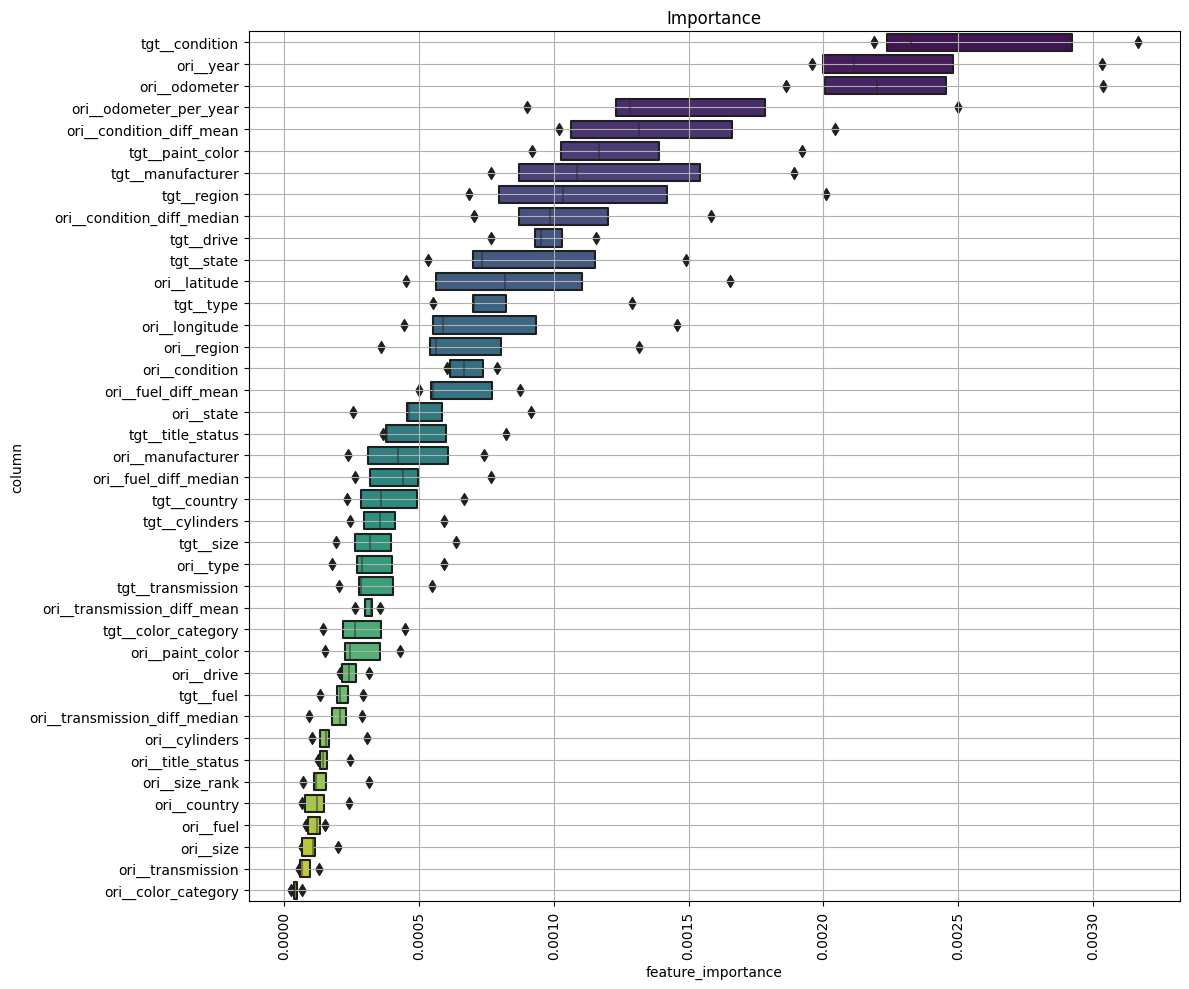

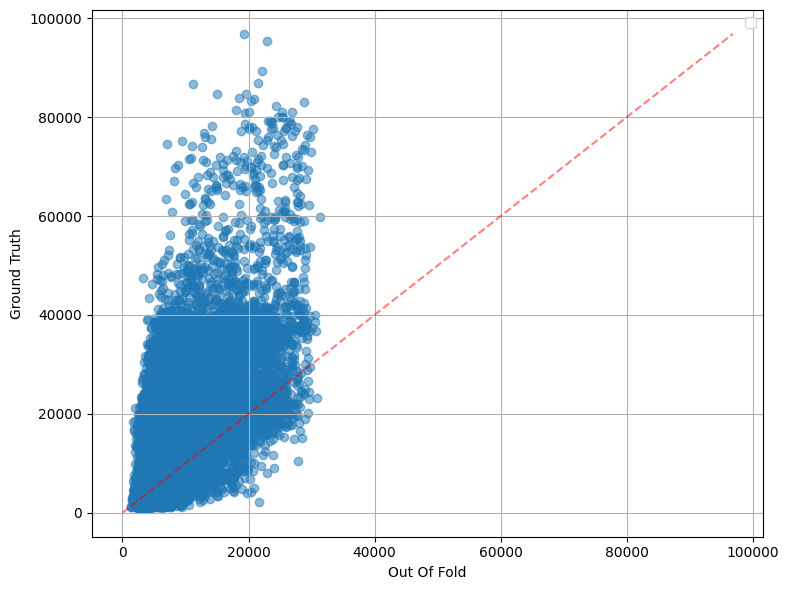

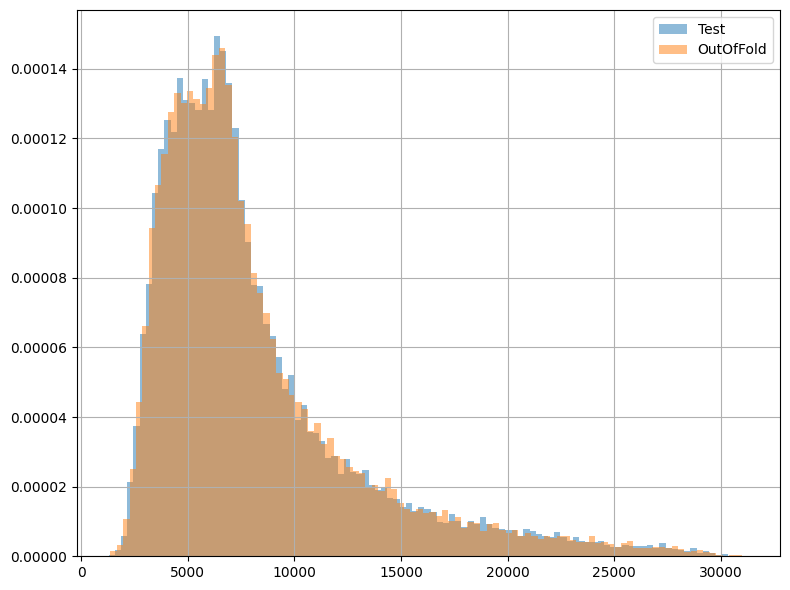

In [62]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)

In [ ]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)

In [ ]:
df.isnull().sum()

In [ ]:
train_df.isnull().sum()

In [ ]:
test_df.isnull().sum()

In [57]:
train_df[train_df['odometer'] < 0]['odometer'].sum()

-265

In [63]:
train_feat_df.to_csv('train_feat_df.csv')

In [64]:
test_feat_df.to_csv('test_feat_df.csv')